In [5]:
from pylab import *
import pymesh
from mixture import GaussianMixture

def get_centroids(mesh):
    # obtain a vertex for each face index
    face_vert = mesh.vertices[mesh.faces.reshape(-1),:].reshape((mesh.faces.shape[0],3,-1))
    # face_vert is size (faces,3(one for each vert), 3(one for each dimension))
    centroids = face_vert.sum(1)/3.0
    #face_vert = ((face_vert.shape[0]/SAMPLE_PTS)*(face_vert.reshape((-1,9))-np.repeat(centroids,3,axis=1)) + np.repeat(centroids,3,axis=1)).reshape((-1,3,3))
    ABAC = face_vert[:,1:3,:] - face_vert[:,0:1,:]
    areas = np.linalg.norm(np.cross(ABAC[:,0,:],ABAC[:,1,:]),axis=1)/2.0
    return centroids, areas

def get_tri_covar(tris):
    covars = []
    for face in face_vert:
        A = face[0][:,None]
        B = face[1][:,None]
        C = face[2][:,None]
        M = (A+B+C)/3
        covars.append(A @ A.T + B @ B.T + C @ C.T - 3* M @ M.T)
    return np.array(covars)*(1/12.0)


In [448]:
import transforms3d
mesh0 = pymesh.load_mesh("bunny/bun_zipper_1000_1.ply")
K = 100
com,a = get_centroids(mesh0)
center = mesh0.vertices.mean(0)
com -= center
print(com.shape)
face_vert = mesh0.vertices[mesh0.faces.reshape(-1),:].reshape((mesh0.faces.shape[0],3,-1)) - center
R = np.identity(3)
R = transforms3d.euler.euler2mat(0,np.pi/2,np.pi/2, 'sxyz')
R = transforms3d.euler.euler2mat(np.pi,0,np.pi, 'sxyz') @ R

face_vert = face_vert @ R
com = com @ R

data_covar = get_tri_covar(face_vert)
print(data_covar.shape)

(1000, 3)
(1000, 3, 3)


In [493]:
gm_mesh_kmeans = GaussianMixture(K,init_params='kmeans',tol=1e-9,max_iter=250); gm_mesh_kmeans.set_covars(data_covar); gm_mesh_kmeans.set_areas(a); gm_mesh_kmeans.fit(com); gm_mesh_kmeans.set_covars(None); gm_mesh_kmeans.set_areas(None)
#gm_mesh_kmeans = GaussianMixture(K,init_params='kmeans',tol=1e-9,max_iter=250);  gm_mesh_kmeans.fit(com);

In [442]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource


fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
b2 = np.array(face_vert)
minb = b2.reshape((-1,3)).min(0)
maxb = b2.reshape((-1,3)).max(0)
meanb = b2.reshape((-1,3)).mean(0)
span = maxb-minb
w = np.max(span) * np.ones(3)
pc = Poly3DCollection(face_vert, alpha = 0.75, facecolor='#1f77b4', linewidths=1,edgecolors=np.array([0.7,0.0,0.5,0.4]))
ax.add_collection3d(pc)
ax.set_xlim(minb[0]-w[0],maxb[0]+w[0])
ax.set_ylim(minb[1]-w[1],maxb[1]+w[1])
ax.set_zlim(minb[2]-w[2],maxb[2]+w[2])
ax.set_proj_type('persp')


# Hide grid lines
ax.grid(False)



# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(26,-28)
plt.axis('off')
ax.dist = 3

xlm=ax.get_xlim3d() #These are two tupples
ylm=ax.get_ylim3d() #we use them in the next
zlm=ax.get_zlim3d() #graph to reproduce the magnification from mousing

ax.set_xlim3d(xlm[0]-0.04,xlm[1]-0.04)     #Reproduce magnification
ax.set_ylim3d(ylm[0],ylm[1])     #...
ax.set_zlim3d(zlm[0],zlm[1])     #...

ax = fig.add_subplot(1, 2, 2, projection='3d')
#plot_gmm_contour(ax, gm_mesh_kmeans.means_, gm_mesh_kmeans.covariances_, gm_mesh_kmeans.weights_)
points=10000
z = []
c = []
colors = plt.cm.tab10(np.arange(10)/10) #plt.rcParams['axes.prop_cycle'].by_key()['color']
means,covars,weights = com,data_covar,a/np.sum(a)#gm_mesh_kmeans.means_, gm_mesh_kmeans.covariances_, gm_mesh_kmeans.weights_
for e,i in enumerate([14,428,412,446,451,411,439,477]):#range(means.shape[0]):
    if np.random.rand() < 5:
        samples = int(round(points*weights[i]))
        z.append(np.random.multivariate_normal(means[i],covars[i],samples))
        c += [colors[e%10] for _ in range(samples)]
z = np.vstack(z)
c = np.vstack(c)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(26,-28)
plt.axis('off')
ax.set_proj_type('persp')

ax.dist = 3
pc = Poly3DCollection(face_vert, alpha = 0.1, facecolor='#ffffff', linewidths=1,edgecolors=np.array([0.7,0.0,0.5,0.1]))
ax.add_collection3d(pc)
#ax.scatter(z[:,0],z[:,1],z[:,2],c=c,depthshade=False)

ax.set_xlim3d(xlm[0]-0.04,xlm[1]-0.04)     #Reproduce magnification
ax.set_ylim3d(ylm[0],ylm[1])     #...
ax.set_zlim3d(zlm[0],zlm[1])     #...

faces_of_interest = [14,428,412,446,451,411,439,477]
for e,i in enumerate(faces_of_interest):#range(means.shape[0]):
    mean,covar = means[i],covars[i]
    u,s,vt = np.linalg.svd(covar)
    coefs = (.002, .002, .002)  # Coefficients in a0/c x**2 + a1/c y**2 + a2/c z**2 = 1 
    # Radii corresponding to the coefficients:
    rx, ry, rz = 1.5*np.sqrt(s)#s#1/np.sqrt(coefs)
    
    R_reg = vt.T @ np.diag([1,1,np.linalg.det(vt.T @ u.T)]) @ u.T
    
    #print(eigs)
    # Set of all spherical angles:
    u = np.linspace(0, 2 * np.pi, 25)
    v = np.linspace(0, np.pi, 25)

    # Cartesian coordinates that correspond to the spherical angles:
    # (this is the equation of an ellipsoid):
    x = rx * np.outer(np.cos(u), np.sin(v)) #+ mean[0]
    y = ry * np.outer(np.sin(u), np.sin(v)) #+ mean[1]
    z = rz * np.outer(np.ones_like(u), np.cos(v)) #+ mean[2]
    
    for i in range(len(x)):
        for j in range(len(x)):
            x[i,j],y[i,j],z[i,j] = np.dot([x[i,j],y[i,j],z[i,j]], vt) + mean    
    # Plot:
    ax.plot_surface(x,y,z,  color=colors[e%10],shade=False,linewidth=0.0)
pc = Poly3DCollection(face_vert[faces_of_interest], alpha = 0.0, facecolor='#ffffff', linewidths=2,edgecolors=np.array([0.7,0.0,0.5,0.5]))
ax.add_collection3d(pc)
plt.tight_layout()
plt.savefig('bunny_head.pdf')

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


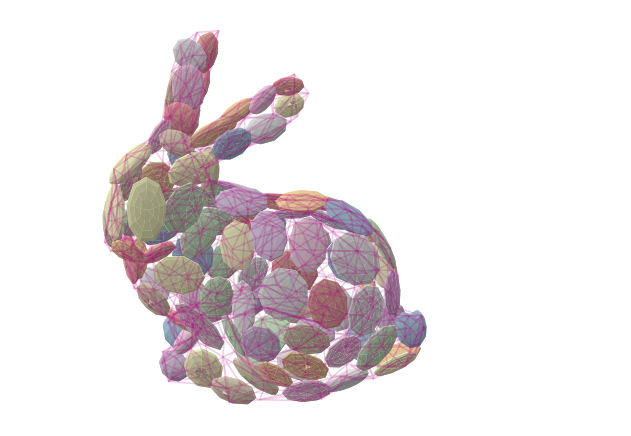

/Users/lkeselma/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [494]:
sz = 4
fig = plt.figure(figsize=(1.4475*sz,sz))
padw = (1.4475-1)/2
#ax = fig.add_subplot(1, 1, 1, projection='3d')#Axes3D(fig)
# L B W H
ax = Axes3D(fig, [0, -0.15, 1-padw, 1.1], )
#plot_gmm_contour(ax, gm_mesh_kmeans.means_, gm_mesh_kmeans.covariances_, gm_mesh_kmeans.weights_)
points=10000
z = []
c = []
ax.autoscale_view(tight=True, scalex=False, scaley=False, scalez=False)

pc = Poly3DCollection(face_vert, alpha = 0.01, facecolor='#ffffff', linewidths=1,edgecolors=np.array([0.7,0.0,0.5,0.1]))
ax.add_collection3d(pc)
#ax.scatter(z[:,0],z[:,1],z[:,2],c=c,depthshade=False)

means,covars,weights = gm_mesh_kmeans.means_, gm_mesh_kmeans.covariances_, gm_mesh_kmeans.weights_

colors = plt.cm.Pastel1(np.arange(means.shape[0])/(means.shape[0])) #plt.rcParams['axes.prop_cycle'].by_key()['color']
np.random.shuffle(colors)

faces_of_interest = [14,428,412,446,451,411,439,477]
for i in range(means.shape[0]):
    orig_i = i
    mean,covar = means[i],covars[i]
    u,s,vt = np.linalg.svd(covar)
    coefs = (.002, .002, .002)  # Coefficients in a0/c x**2 + a1/c y**2 + a2/c z**2 = 1 
    # Radii corresponding to the coefficients:
    rx, ry, rz = 1.7*np.sqrt(s)#s#1/np.sqrt(coefs)
    
    R_reg = vt.T @ np.diag([1,1,np.linalg.det(vt.T @ u.T)]) @ u.T
    
    #print(eigs)
    # Set of all spherical angles:
    u = np.linspace(0, 2 * np.pi, 10)
    v = np.linspace(0, np.pi, 10)

    # Cartesian coordinates that correspond to the spherical angles:
    # (this is the equation of an ellipsoid):
    x = rx * np.outer(np.cos(u), np.sin(v)) #+ mean[0]
    y = ry * np.outer(np.sin(u), np.sin(v)) #+ mean[1]
    z = rz * np.outer(np.ones_like(u), np.cos(v)) #+ mean[2]
    
    for i in range(len(x)):
        for j in range(len(x)):
            x[i,j],y[i,j],z[i,j] = np.dot([x[i,j],y[i,j],z[i,j]], vt) + mean    
    # Plot:
    res = ax.plot_surface(x,y,z,  color=colors[orig_i],shade=True,linewidth=0.0)
plt.tight_layout()

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(39.4,14)
plt.axis('off')
ax.set_proj_type('persp')
ax.dist = 4.2
ax.set_xlim(meanb[0]-w[0],meanb[0]+w[0])
ax.set_ylim(meanb[1]-w[1],meanb[1]+w[1])
ax.set_zlim(meanb[2]-w[2],meanb[2]+w[2])
ax.set_proj_type('persp')
plt.tight_layout()
plt.savefig('bunny_gmm_k100_mesh.pdf')
plt.show()

In [444]:
res[0]

TypeError: 'Poly3DCollection' object does not support indexing